In [34]:
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage import morphology
from scipy import ndimage

from matplotlib.widgets import RectangleSelector

In [2]:
folder = '/scicore/home/nimwegen/witzg/DeepPlateAnalysis/usingsubset6/Analysis_201710126_lowerbound/'

In [3]:
def seg_import(pos):
    mask = label(np.load(folder+'mask_'+str(pos)+'.npy'))
    corr = np.load(folder+'corr_'+str(pos)+'.npy')
    prob = np.load(folder+'prob_'+str(pos)+'.npy')
    return corr, mask, prob

In [4]:
def proba_thresh(prob,thresh):
    plate_im_mask2 = prob.copy()
    plate_im_mask2[plate_im_mask2<thresh]=0
    plate_im_mask2[plate_im_mask2>thresh]=1

    masklab = morphology.label(plate_im_mask2)
    cellinfo = regionprops(masklab)
    newMask = np.zeros(masklab.shape)
    for c in cellinfo:
        if (c.label>0)&(c.area>100)&(c.area<10000):#&(c.solidity>0.8)&(c.eccentricity>0.6):
            newMask[masklab==c.label]=1
    return newMask

In [5]:
class Kymobuilder:
    def __init__(self, fig):
        self.pos = 0
        self.thresh = 0.1
        self.fig = fig
        [self.corr, self.mask, self.prob] = seg_import(self.pos)
        self.mask = proba_thresh(self.prob,self.thresh)
        self.mask = label(self.mask)
        
        self.xs = []#list(line.get_xdata())
        self.ys = []#list(line.get_ydata())
        self.shift_is_held = False
        self.ctrl_is_held = False
        
        self.fig.clear()
        ax = self.fig.add_subplot(111)
        ax.set_title('position'+str(self.pos))
        ax.imshow(self.corr,cmap = 'gray')
        ax.imshow(label2rgb(self.mask,bg_label=0),alpha = 0.4)
        self.fig.canvas.draw()
    
    def connect(self):
        'connect to all the events we need'
        self.cidpress = self.fig.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidshifton = self.fig.canvas.mpl_connect(
            'key_press_event', self.on_key_press)
        self.cidshiftoff = self.fig.canvas.mpl_connect(
            'key_release_event', self.on_key_release)
        
    

    def on_press(self, event):
        
        if self.ctrl_is_held==True:
            truc=1
        elif self.shift_is_held==True:
            truc=2
        else:
            xs = int(event.xdata)
            ys = int(event.ydata)
            #self.xs.append(event.xdata)
            #self.ys.append(event.ydata)
            val = self.mask[ys,xs]
            self.mask[self.mask == val]=0
        
        self.fig.clear()
        plt.cla()
        ax = self.fig.add_subplot(111)
        #ax.set_title('position'+str(self.pos))
        ax.set_title('position'+str(val)+' '+str(xs)+' '+str(ys)+' '+str(np.sum(self.mask == val)))
        ax.imshow(self.corr,cmap = 'gray')
        ax.imshow(label2rgb(self.mask,bg_label=0),alpha = 0.4)
        self.fig.canvas.draw()
    
    def on_key_press(self,event):
        print(event.key)
        if event.key == 'a':
            masktosave = self.mask.copy()
            masktosave[masktosave>0]=1
            np.save(folder+'maskcorrect_'+str(self.pos)+'.npy',masktosave)
        if event.key == 'shift':
            self.shift_is_held = True
        if event.key == 'control':
            self.ctrl_is_held = True
        if event.key == 'right':
            self.pos = self.pos+1
            self.fig.clear()
            plt.cla()

            [self.corr, self.mask, self.prob] = seg_import(self.pos)
            self.mask = proba_thresh(self.prob,self.thresh)
            self.mask = label(self.mask)
            ax = self.fig.add_subplot(111)
            ax.set_title('position'+str(self.pos))
            ax.imshow(self.corr,cmap = 'gray')
            ax.imshow(label2rgb(self.mask,bg_label=0),alpha = 0.4)
            self.fig.canvas.draw()
            
            
        
        if event.key == 'left':
            if self.pos >0:
                self.pos = self.pos-1
                self.fig.clear()
                plt.cla()

                [self.corr, self.mask, self.prob] = seg_import(self.pos)
                self.mask = proba_thresh(self.prob,self.thresh)
                self.mask = label(self.mask)
                ax = self.fig.add_subplot(111)
                ax.set_title('position'+str(self.pos))
                ax.imshow(self.corr,cmap = 'gray')
                ax.imshow(label2rgb(self.mask,bg_label=0),alpha = 0.4)
                self.fig.canvas.draw()
        if event.key == 'up':
            self.thresh +=0.05
            self.mask = proba_thresh(self.prob,self.thresh)
            self.mask = label(self.mask)
            self.fig.clear()
            #plt.cla()
            ax = self.fig.add_subplot(111)
            ax.set_title('position'+str(self.pos))
            ax.imshow(self.corr,cmap = 'gray')
            ax.imshow(label2rgb(self.mask,bg_label=0),alpha = 0.4)
            self.fig.canvas.draw()
        if event.key == 'down':
            self.thresh -=0.05
            self.mask = proba_thresh(self.prob,self.thresh)
            self.mask = label(self.mask)
            self.fig.clear()
            ax = self.fig.add_subplot(111)
            ax.set_title('position'+str(self.pos))
            ax.imshow(self.corr,cmap = 'gray')
            ax.imshow(label2rgb(self.mask,bg_label=0),alpha = 0.4)
            self.fig.canvas.draw()
            
    def on_key_release(self,event):
        if event.key == 'shift':
            self.shift_is_held = False
        if event.key == 'control':
            self.ctrl_is_held = False



<IPython.core.display.Javascript object>


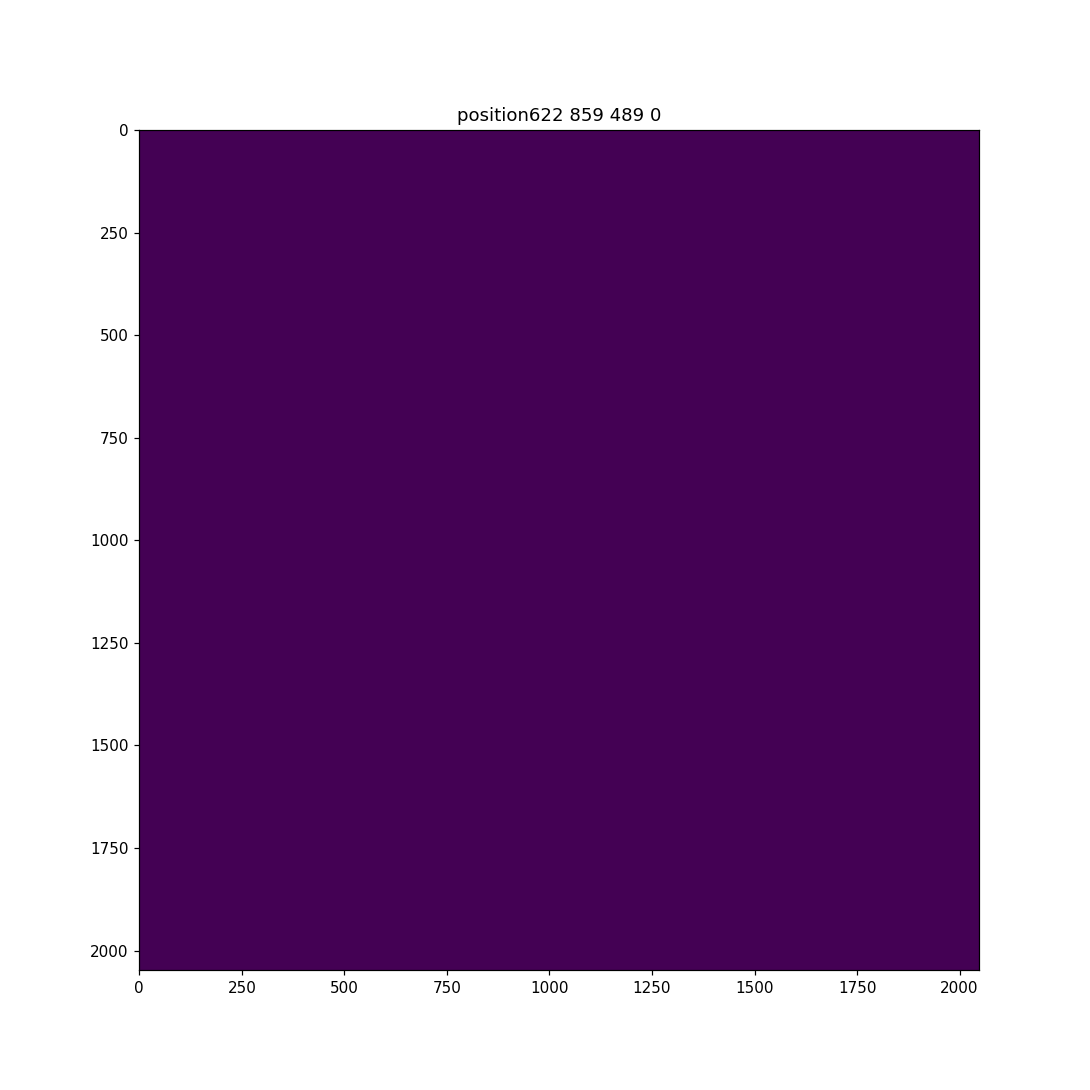

In [6]:
%matplotlib notebook
    
fig, ax = plt.subplots(figsize=(10,10))
#ax = fig.add_subplot(111)
ax.set_title('click to build line segments')
ax.imshow(np.random.rand(5,10))
linebuilder = Kymobuilder(fig)
linebuilder.connect()

plt.show()

In [26]:
posid = [re.findall('(?<=maskcorrect_)(\d+)(?=\.npy)',f) for f in os.listdir(folder)]

In [30]:
posid = [int(x[0]) for x in posid if len(x)>0]

In [32]:
mask = label(np.load(folder+'maskcorrect_'+str(posid[0])+'.npy'))

In [52]:
for i in range(len(posid)):
    mask = np.load(folder+'maskcorrect_'+str(posid[i])+'.npy')
    distance = ndimage.distance_transform_edt(mask)
    distance[distance != 1] = 0
    distance = morphology.binary_dilation(distance)
    distance[mask==1] = 0
    np.save(folder+'weightcorrect_'+str(posid[i])+'.npy',distance)   

In [36]:
for i in range(len(posid)):
    mask = np.load(folder+'maskcorrect_'+str(posid[i])+'.npy')
    masklab = morphology.label(mask)
    cellinfo = regionprops(masklab)

    masktot = np.zeros(mask.shape)
    dist_tot = np.zeros(mask.shape)
    for c in cellinfo:

        loc_mask = np.zeros(mask.shape)
        loc_mask[masklab == c.label]=1

        distance = ndimage.distance_transform_edt(loc_mask)
        distance[distance != 1] = 0
        distance = morphology.binary_dilation(distance)
        distance[loc_mask==1] = 0

        dist_tot = dist_tot+distance

    dist_tot[dist_tot>0]=1
    np.save(folder+'weightcorrect_'+str(posid[i])+'.npy',dist_tot)    


KeyboardInterrupt: 

In [42]:
%matplotlib inline

In [56]:
mask = label(np.load(folder+'maskcorrect_'+str(posid[0])+'.npy'))
all_correlations = np.empty((mask.shape[0],mask.shape[1],len(posid)))
all_masks = np.empty((mask.shape[0],mask.shape[1],len(posid)))
all_weights = np.empty((mask.shape[0],mask.shape[1],len(posid)))

for i in range(len(posid)):
    all_masks[:,:,i] = np.load(folder+'maskcorrect_'+str(posid[i])+'.npy')
    all_weights[:,:,i] = np.load(folder+'weightcorrect_'+str(posid[i])+'.npy')
    all_correlations[:,:,i] = np.load(folder+'corr_'+str(posid[i])+'.npy')
    

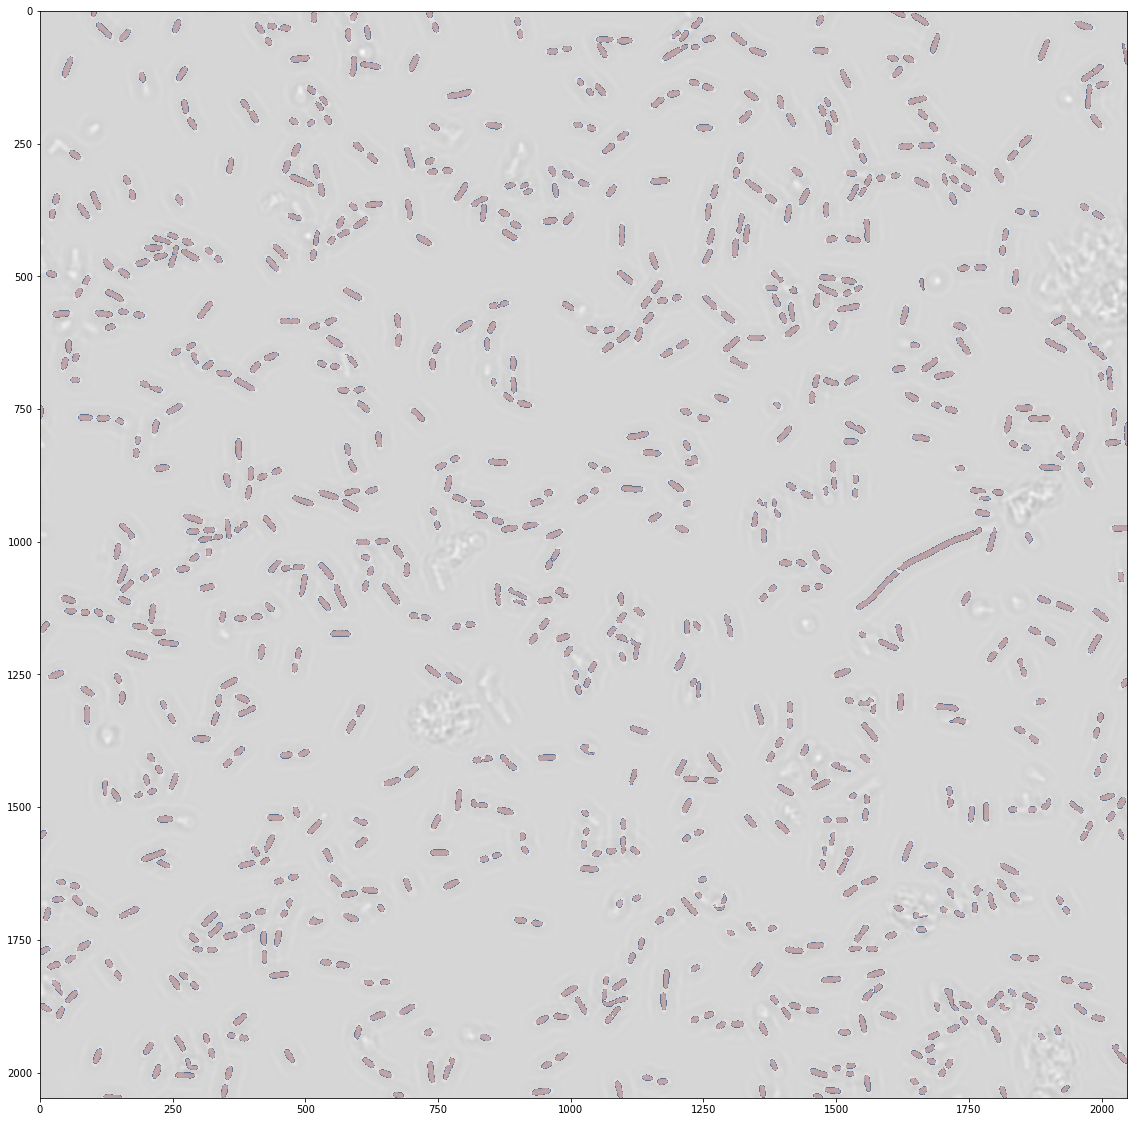

In [60]:
fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(all_correlations[:,:,3],cmap= 'gray')
plt.imshow(all_masks[:,:,3],alpha = 0.5,cmap='Reds')
plt.imshow(all_weights[:,:,3],alpha = 0.5,cmap='Blues')
plt.show()

In [61]:
np.sum(all_masks)/(all_masks.shape[0]*all_masks.shape[1]*all_masks.shape[2])*100

4.0044289368849535

In [64]:
numsplits = int(all_masks.shape[0]/128)
numimages = all_masks.shape[2]

#Definition of structures containing training and test datasets
#Dimensions and size of training and test datasets
channels = 1
image_rows = 128
image_cols = 128
num_test = 20
num_train = 2*((numsplits**2*numimages)-num_test)


imgs = np.ndarray((num_train, image_rows, image_cols,channels), dtype=np.float64)
imgs_mask = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_weight = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_test = np.ndarray((num_test, image_rows, image_cols,channels), dtype=np.float64)
imgs_id = np.ndarray((num_test, ), dtype=np.int32)

listpos = []
for k in range(numimages):
    for i in range(numsplits):
        for j in range(numsplits):
            listpos.append([i,j,k])
            
shuffle = np.random.choice(len(listpos), len(listpos), replace=False)

all_weights[all_weights==1] = 200
all_weights[all_masks==1] = 20
all_weights[all_weights==0] = 1

In [65]:
np.unique(all_weights)

array([  1.,  20., 200.])

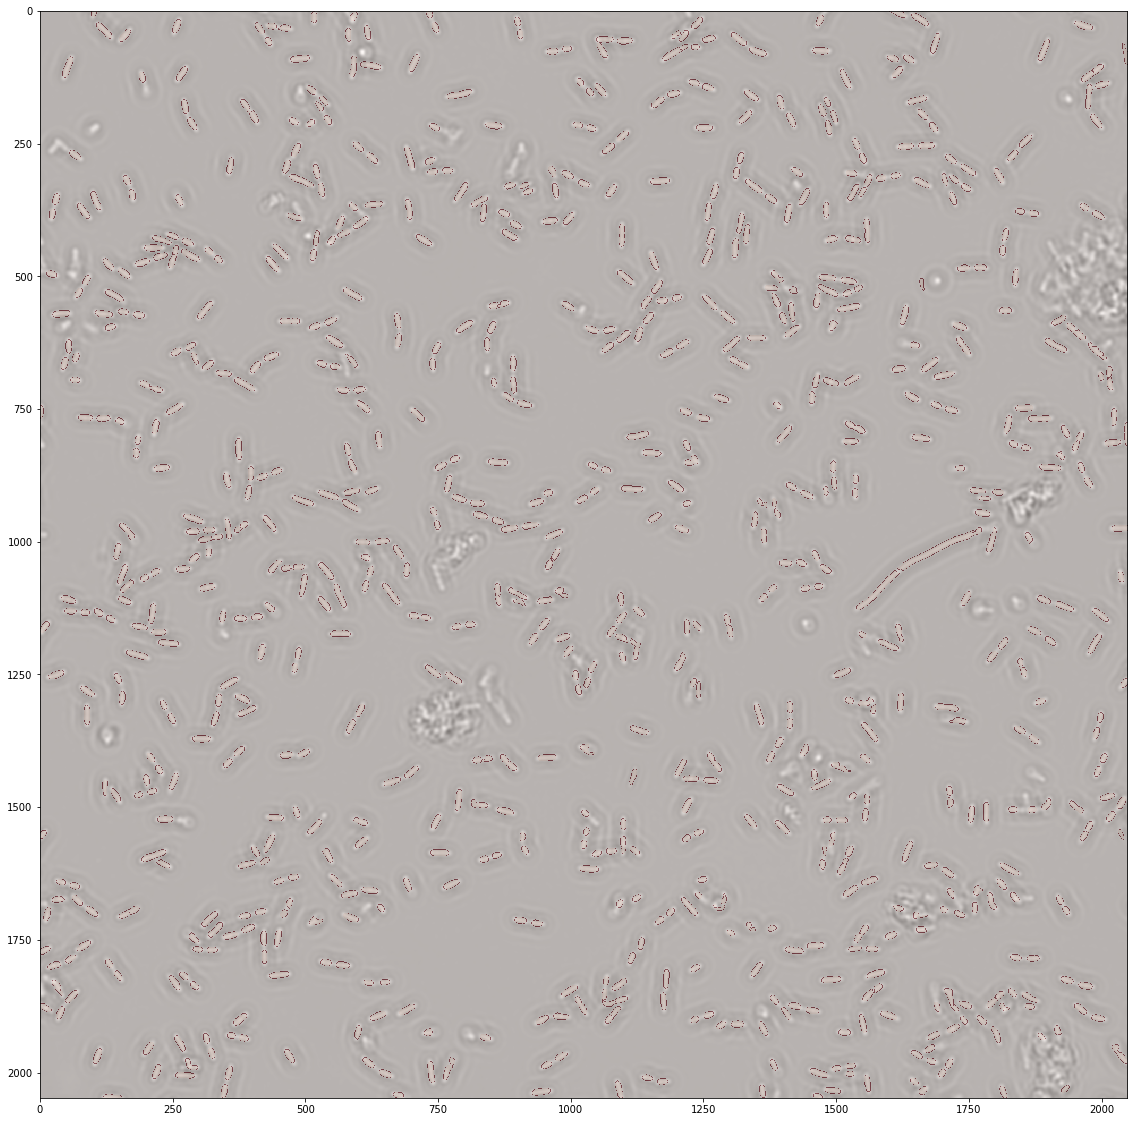

In [66]:
fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(all_correlations[:,:,3],cmap= 'gray')
plt.imshow(all_weights[:,:,3],alpha = 0.5,cmap='Reds')
plt.show()

In [72]:
counter_test = 0
for counter in range(len(listpos)):
    i=listpos[shuffle[counter]][0]
    j=listpos[shuffle[counter]][1]
    k=listpos[shuffle[counter]][2]
    
    img = all_correlations[i*128:(i+1)*128,j*128:(j+1)*128,k]
    randint = np.random.rand() 
    if np.random.rand()<0.5: randint = 10*randint
    #randint = 100*randint
    img = img*randint
    img_mask = 255*all_masks[i*128:(i+1)*128,j*128:(j+1)*128,k]
    img_weight = all_weights[i*128:(i+1)*128,j*128:(j+1)*128,k]
            
    if 2*counter<num_train:
        if channels==1:
            imgs[2*counter] = img[..., np.newaxis]
            img = img.T
            imgs[2*counter+1] = img[..., np.newaxis]
        else:
            imgs[2*counter] = img
            img = img.T
            imgs[2*counter+1] = img
        imgs_mask[2*counter] = img_mask
        img_mask = img_mask.T
        imgs_mask[2*counter+1] = img_mask
        imgs_weight[2*counter] = img_weight
        img_weight = img_weight.T
        imgs_weight[2*counter+1] = img_weight
    else:
        if channels==1:
            imgs_test[counter_test] = img[..., np.newaxis]
        else:
            imgs_test[counter_test] = img

        imgs_id[counter_test] = counter_test
        counter_test+=1

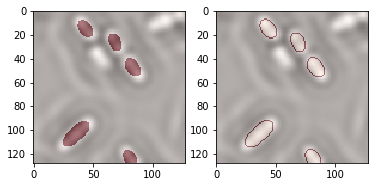

In [92]:
#check individul examples of training set
plt.subplot(1,2,1)
id = 13272-10
plt.imshow(imgs[id,:,:,0],cmap = 'gray')
plt.imshow(np.reshape(imgs_mask[id,:],(image_rows,image_cols)),alpha = 0.5, cmap = 'Reds')
plt.subplot(1,2,2)
plt.imshow(imgs[id,:,:,0],cmap = 'gray')
plt.imshow(np.reshape(imgs_weight[id,:],(image_rows,image_cols)),alpha = 0.5, cmap = 'Reds')
plt.show()

In [93]:
path_to_save = '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_manual/'

#save all the data structures
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
np.save(path_to_save+'imgs_train.npy', imgs)
np.save(path_to_save+'imgs_mask_train.npy', imgs_mask.reshape((num_train,image_cols*image_rows)))
np.save(path_to_save+'imgs_weight_train.npy', imgs_weight.reshape((num_train,image_cols*image_rows)))
np.save(path_to_save+'imgs_test.npy', imgs_test)
np.save(path_to_save+'imgs_id_test.npy', imgs_id)